<a href="https://colab.research.google.com/github/Beauremontt/AGN-Flux-Timing-Analysis/blob/main/AGNFluxTimingAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code Cells

## 1 Initialization

### 1.1 Modules & Functions

In [247]:
import numpy as np  # for math and arrays
import matplotlib.pyplot as plt  # for plotting

import requests # for loading urls
from io import StringIO # for treating strings as file-like objects

from astropy.timeseries import LombScargle  # for the periodograms


# plots light curve and prints some preliminary info
def display_data(prefix):

  plt.subplots(1, 1, figsize=(12, 8))
  plt.errorbar(x/86400, y, yerr=dy, fmt='_k', ecolor='c', elinewidth=1)
  plt.title(f'{prefix} light curve for {flux_source}\n{band_label}', fontsize=24)
  plt.xlabel('MJD', fontsize=24)
  plt.ylabel('Flux', fontsize=24)
  if lc_xlim != None: plt.xlim(lc_xlim)
  if lc_ylim != None: plt.ylim(lc_ylim)
  plt.tick_params(labelsize=18)
  plt.show()

  print("\nNumber of data points =", NumData, "Start MJD =", x[0]/86400, "End MJD =", x[NumData - 1]/86400)
  print("Data Span =", Span/86400, "days",)
  print("Mean Spacing =", MeanSpacing/86400, "days")

### 1.2 Load data

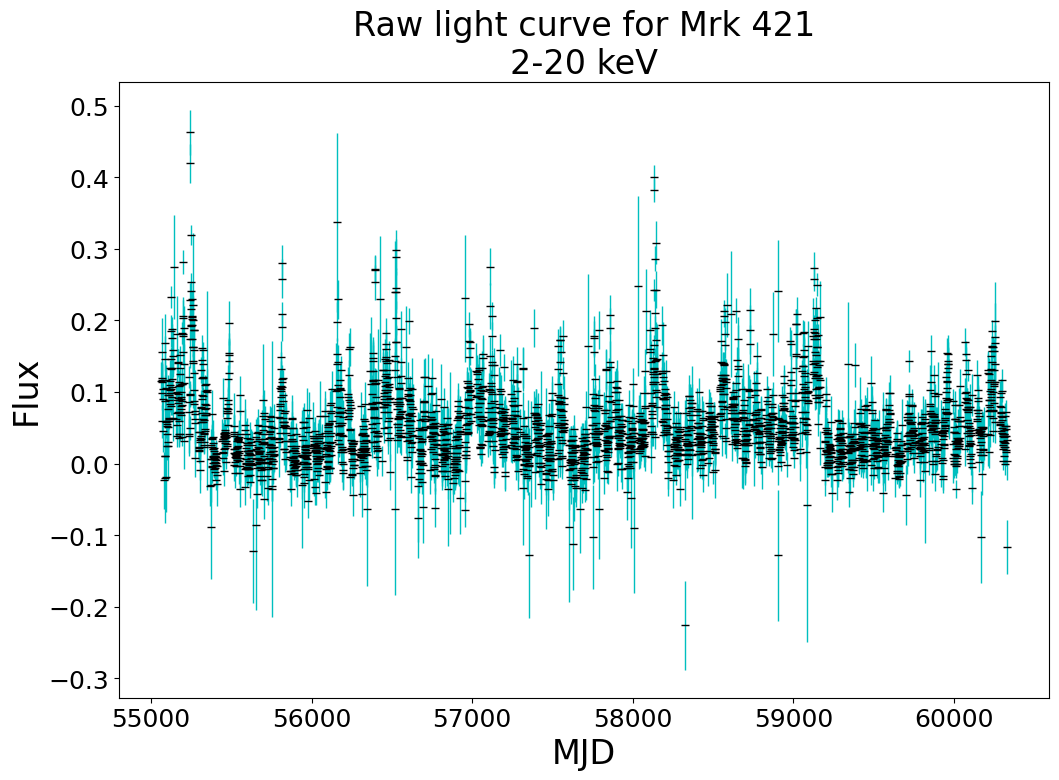


Number of data points = 3285 Start MJD = 55064.5 End MJD = 60330.5
Data Span = 5266.0 days
Mean Spacing = 1.6035322777101098 days


In [248]:
# @title  { form-width: "40%" }

# url of the flux data
url = "http://maxi.riken.jp/star_data/J1104+382/J1104+382_g_lc_1day_all.dat" # @param {type:"string"}

# filename if you choose not to pull from url
filename = "" # @param {type:"string"}

# name of the AGN to display on plots
flux_source = "Mrk 421"  # @param {type:"string"}

# energy range of the flux measurements; prints below flux_source on plots
band_label = "2-20 keV"  # @param {type:"string"}

# which energy range to use; value is ordinal and depends on the archive
  # MAXI includes four different bands in each data file: 2-20, 2-4, 4-10, and 10-20 keV
energy_band = 1 # @param {type:"slider", min:1, max:4, step:1}
# the data column the chosen band corresponds to
flux_column = (energy_band-1)*2 + 1

# number of lines to skip at the beginning of the file
  # `np.genfromtxt` automatically skips commented lines (rows beginning with '#')
skip_header = 0  # @param {type:"integer"}

# number of lines to skip at bottom
skip_footer = 0  # @param {type:"integer"}

# whether or not to print the unfiltered light curve
display_raw = True  # @param {type:"boolean"}


# choose txt_content from inputs; prioritizes urls
if url != "":
  # fetch the content from the url
  response = requests.get(url)

  # create a text file-like with the data
  txt_content = StringIO(response.text)
elif filename != "": txt_content = filename
else: raise Exception("No flux data.")


# create an array from the text file
AGN = np.genfromtxt(txt_content, skip_header = skip_header, skip_footer = skip_footer)


# set up the values
x = 86400*AGN[:, 0]  # first column of the data set (MJD midpoint of observation in seconds)
y = AGN[:, flux_column]  # column of the data set (flux)
dy = AGN[:, flux_column + 1]  # next column of the data set (the uncertainty)

# get timespan and spacing of data
NumData = len(x)
Span = x[NumData - 1] - x[0]
MeanSpacing = Span / (NumData - 1)

# get averages of the error and the flux to find the percent error
Error = np.mean(dy)
Mean = np.mean(y)


# plot of light curve
if display_raw == True:

  # x,y limits on light curve, in the form "(lower, upper)"; leave blank or 'None' to not limit the graphs
  lc_xlim = None  # @param {type:"raw"}
  lc_ylim = None  # @param {type:"raw"}

  display_data("Raw")

## 2 Data & Analysis

### 2.1 Filter data

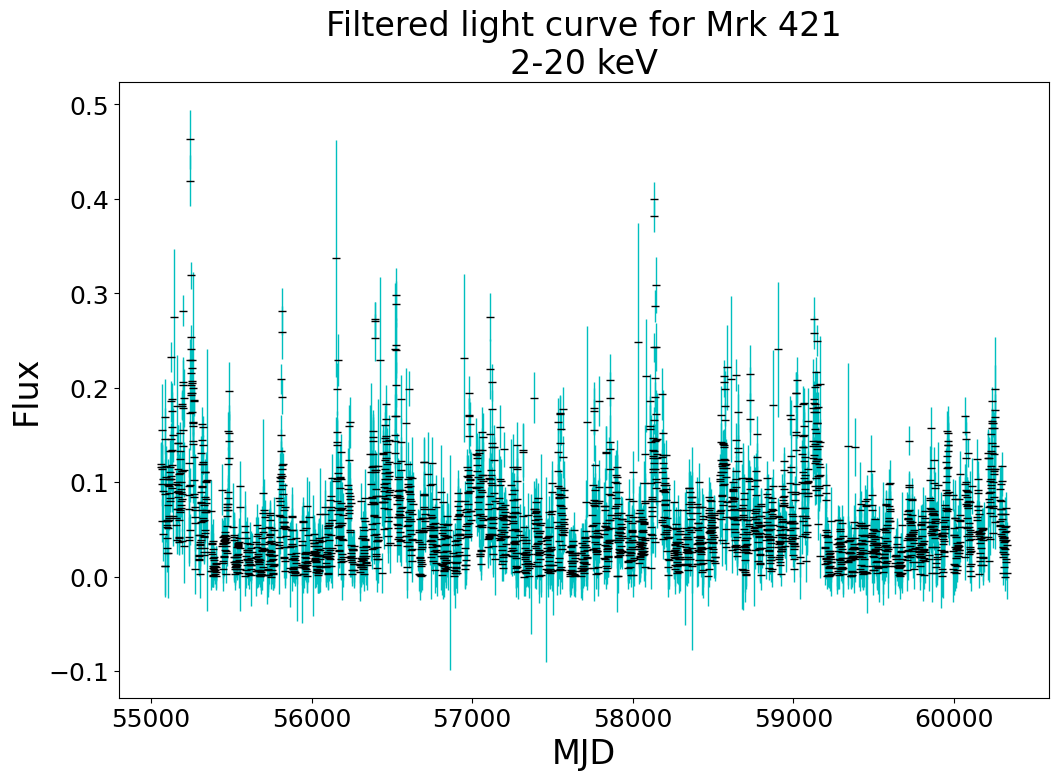


Number of data points = 2956 Start MJD = 55064.5 End MJD = 60329.5
Data Span = 5265.0 days
Mean Spacing = 1.781725888324873 days


In [249]:
# @title  { form-width: "25%" }

# skips this cell if false
use_filter = True # @param {type:"boolean"}


if use_filter == True:

  # reset values
  x = 86400*AGN[:, 0]  # MJD (s)
  y = AGN[:, flux_column]  # Flux
  dy = AGN[:, flux_column + 1]  # uncertainty


  # determine data points to ignore
  rm = []
  for i in range(len(x)):
    if y[i] < 0:  # checks for negative flux
      rm.append(i)
      continue
    if dy[i] > 10**100:  # checks for low SNR flux
      rm.append(i)

  # remove lines marked by filter
  x = np.delete(x, rm)
  y = np.delete(y, rm)
  dy = np.delete(dy, rm)


  # get timespan and spacing of data
  NumData = len(x)
  Span = x[NumData - 1] - x[0]
  MeanSpacing = Span / (NumData - 1)

  # get new averages of the error and the flux
  Error = np.mean(dy)
  Mean = np.mean(y)


  # x,y limits on light curve, in the form "(lower, upper)"; leave blank or 'None' to not limit the graphs
  lc_xlim = None  # @param {type:"raw"}
  lc_ylim = None  # @param {type:"raw"}

  # print filtered light curve
  display_data("Filtered")

### 2.2 Gap Histogram

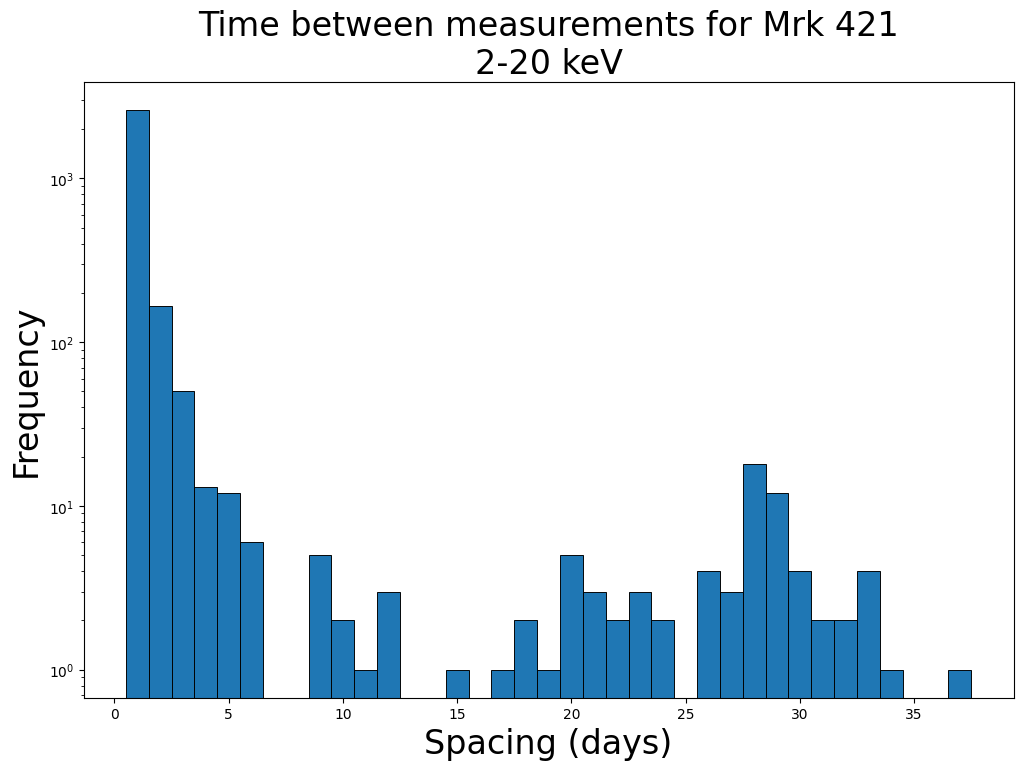

In [250]:
# allocate array for gaps in x
delt_x = []

# get time gaps in days
for i in range(1, len(x)):
  delt_x.append((x[i] - x[i-1])/86400)

# make bins for day increments
max_gap = round(max(delt_x))
min_gap = round(min(delt_x))
bins = np.arange(min_gap, max_gap + 2) - 0.5

# plot histogram
plt.subplots(1,1,figsize=(12,8))
plt.hist(delt_x, bins=bins, align='mid', edgecolor='black', linewidth=25/max_gap)
plt.yscale('log')
plt.title(f'Time between measurements for {flux_source}\n{band_label}', fontsize=24)
plt.xlabel('Spacing (days)', fontsize=24)
plt.ylabel('Frequency', fontsize=24)
plt.show()

### 2.3 Power Spectrum

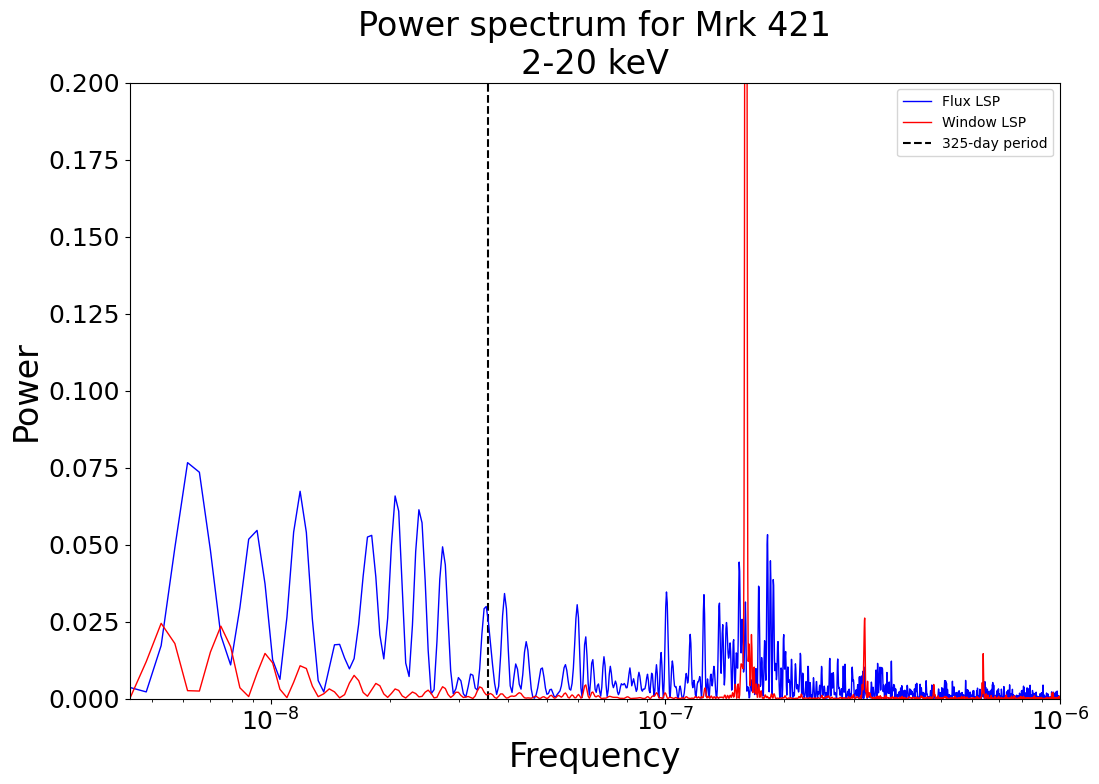

In [251]:
# @title  { form-width: "25%" }


# minimum_frequency, cuts off left of diagram; minif_factor is divided by Span
  #e.g., set to 2 to remove frequencies that would cover more than half the span
minif_factor = 2  # @param {type:"number"}

# nyquist_factor, affects maximum_frequency based on the average nyquist factor
nyquist_factor = 2 # @param {type:"number"}

# period in days to be plotted as a vertical line on the power spectrum
period_bar = 325 # @param {type:"raw"}
if period_bar != (0 or None): frequency_bar = 1/(period_bar*86400)


# data for the periodogram
frequency, power = LombScargle(x, y, dy).autopower(minimum_frequency = minif_factor/Span, nyquist_factor = nyquist_factor)

# get the number of points in the periodogram
A = len(frequency)
B = len(power)


# set up values for Thomas test
yy = 0 * x + 1  #Need to set the y values to one, in order to have the y axis be zero
dyy = 0 * x + 42
ffrequency, ppower = LombScargle(x, yy, dyy).autopower(minimum_frequency = minif_factor/Span, nyquist_factor = nyquist_factor)


# plot of power spectrum
plt.subplots(1,1,figsize=(12,8))
plt.plot(frequency, power, 'b', linewidth=1, label='Flux LSP')
plt.plot(ffrequency, ppower,'r', linewidth=1, label='Window LSP')

# plot vertical line for scrubbing
if period_bar != (0 or None):
  plt.vlines(frequency_bar, np.min((power, ppower)), np.max((power, ppower)), 'black', 'dashed', f'{period_bar}-day period', zorder=1)

# plot labels
plt.xscale('log')
plt.yscale('linear')
plt.title(f'Power spectrum for {flux_source}\n{band_label}', fontsize=24)
plt.xlabel("Frequency", fontsize=24)
plt.ylabel('Power', fontsize=24)
plt.tick_params(labelsize=18)
plt.legend()

# plot limits
# give limits in the form "(lower, upper)"; leave blank to not limit the graphs
lsp_xlim = (min(frequency), 10**-6)  # @param {type:"raw"}
if lsp_xlim != None: plt.xlim(lsp_xlim)
lsp_ylim = (0, 0.2)  # @param {type:"raw"}
if lsp_ylim != None: plt.ylim(lsp_ylim)

plt.show()

### 2.4 Analysis

In [252]:
# finds the maximum and the minimum of the periodogram columns
array = frequency, power
result = np.where(power == np.amax(power))
item = result[0]
fofmax = frequency[item]
period = 1/(fofmax*86400)

# calculate False Alarm Probability [Horne & Baliunas, 1986]
N_i = -6.392 + 1.193 * B + 0.00098 * B ** 2
Mu = np.mean(power)
Sigma = np.std(power)
Z = (np.max(power) - Mu)/Sigma
FAP = 1 - (1 - np.exp(-Z)) ** N_i
altFAP = 1 - (1 - np.exp(-Z)) ** (NumData/2)


# print analysis results
print("\nThe count for frequency is:" , A)
print("\nThe count for power is: " , B)
print("\nThe percent error is: ", ((Error/Mean)*100),)
print("Minimum of the Periodogram: ", np.min(array))
print("Maximum of the Periodogram: ", np.max(array))
print("Index = ", result, item)
print("\nFrequency at Maximum Power", fofmax)
print("Period =", period, "days")
if period < 1: print("       =", period*24*60, "minutes")
print("\nNumber of data points =", NumData, "Start MJD =", x[0]/86400, "End MJD =", x[NumData - 1]/86400)
print("Data Span =", Span/86400, "days",)
print("Mean Spacing =", MeanSpacing/86400, "days")
print("Mean power =", Mu, "  Power standard deviation =", Sigma)
print("Number of independent frequencies [HB86] =", N_i)
print("\nNyquist-limited frequencies =", NumData/2)
print("Z=", Z, "  False Alarm Probability =", FAP)
print("AltFAP (Nyquist) =", altFAP)


The count for frequency is: 14771

The count for power is:  14771

The percent error is:  34.5090816887112
Minimum of the Periodogram:  4.39660933488094e-09
Maximum of the Periodogram:  0.07658345379339901
Index =  (array([4]),) [4]

Frequency at Maximum Power [6.15525307e-09]
Period = [1880.35714286] days

Number of data points = 2956 Start MJD = 55064.5 End MJD = 60329.5
Data Span = 5265.0 days
Mean Spacing = 1.781725888324873 days
Mean power = 0.000786596848577454   Power standard deviation = 0.0032967237009598476
Number of independent frequencies [HB86] = 231434.20317999998

Nyquist-limited frequencies = 1478.0
Z= 22.99157097173571   False Alarm Probability = 2.3950246599180325e-05
AltFAP (Nyquist) = 1.5295442590268493e-07
